# Bayesian linear regression

Last modified: 15/04/2025 by Weipeng

In [245]:
import numpy as np

import jax
import jax.scipy.stats as stats
import jax.numpy as jnp

import blackjax

from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

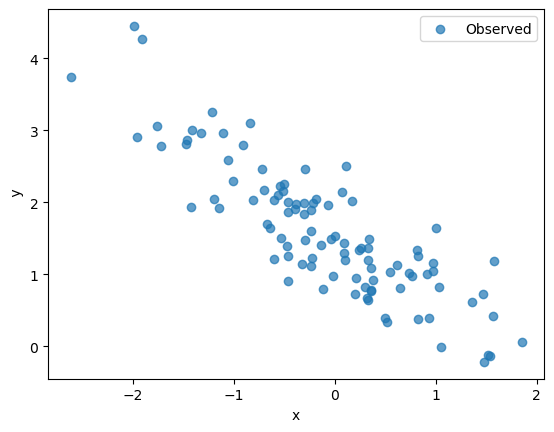

In [246]:
# generate observed data
true_w = np.array([1.5, -0.8])  
true_sigma = 0.5  

N = 100  
X = np.column_stack([np.ones(N), np.random.randn(N, 1)])  
y = X @ true_w + np.random.normal(0, true_sigma, N)  

plt.scatter(X[:, 1], y, alpha=0.7, label="Observed")
plt.xlabel("x"), plt.ylabel(" y")
plt.legend()
plt.show()

In [247]:
# Piror of w
alpha = 1.0  # inverse variance
mu_prior = np.zeros(2)  # piror mu of [w0, w1]
Sigma_prior = (1/alpha) * np.eye(2)  # covariance matrix

In [248]:
# Plot
def post(mcmc_samples):
    print(jnp.mean(jnp.array(mcmc_samples),axis=0))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(mcmc_samples[:, 0], label="w0")
    plt.plot(mcmc_samples[:, 1], label="w1")
    plt.title("MCMC trace")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], alpha=0.1)
    plt.xlabel("w0"), plt.ylabel("w1")
    plt.title("Joint post")
    plt.show()

## 1. Analytical implementation

Post mu: [ 1.50019035 -0.86944354]
Post sigma ** 2:
[[0.00252652 0.00031618]
 [0.00031618 0.00305232]]


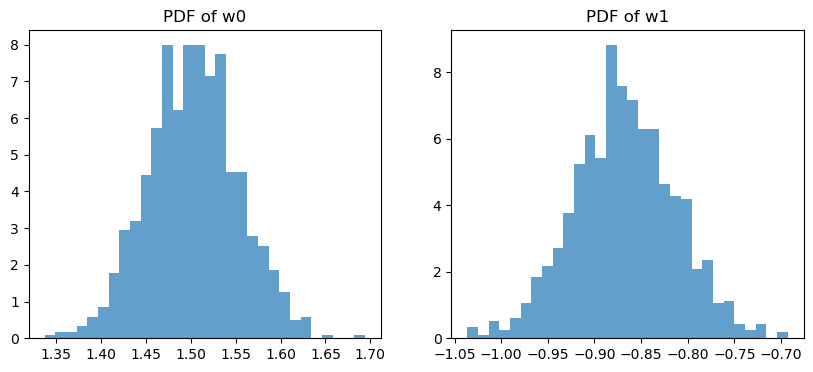

In [249]:
Sigma_inv = np.linalg.inv(Sigma_prior) + (1/true_sigma**2) * X.T @ X
Sigma_posterior = np.linalg.inv(Sigma_inv)
mu_posterior = Sigma_posterior @ (Sigma_inv @ mu_prior + (1/true_sigma**2) * X.T @ y)

print(f"Post mu: {mu_posterior}")
print(f"Post sigma ** 2:\n{Sigma_posterior}")

w0_samples = np.random.normal(mu_posterior[0], np.sqrt(Sigma_posterior[0, 0]), 1000)
w1_samples = np.random.normal(mu_posterior[1], np.sqrt(Sigma_posterior[1, 1]), 1000)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(w0_samples, bins=30, density=True, alpha=0.7)
plt.title("PDF of w0")
plt.subplot(1, 2, 2)
plt.hist(w1_samples, bins=30, density=True, alpha=0.7)
plt.title("PDF of w1")
plt.show()

## 2. Manual Metropolis-Hastings (MH) sampling

In [250]:
def norm_pdf(W, Mu, Sigma2, log_mode=False):
    pdf_fns = stats.multivariate_normal.logpdf if log_mode else stats.multivariate_normal.pdf
    return pdf_fns(jnp.array(W), mean=Mu, cov=Sigma2)

multi_val = norm_pdf(mu_prior, mu_prior, Sigma_prior, log_mode=True)
single_val = np.sum([norm_pdf(mu_prior[i], mu_prior[i], Sigma_prior[i,i], log_mode=True) for i in range(len(mu_prior))])
# Only equal when Covariance matrix is a diagonal matrix
print(f"Multi: {multi_val:.6e}")
print(f"Sum-Single: {single_val:.6e}")

Multi: -1.837877e+00
Sum-Single: -1.837877e+00


In [251]:
def log_posterior(w):
    
    # log_prior = norm_pdf(w, mu_prior, Sigma_prior, log_mode=True)
    log_prior = stats.multivariate_normal.logpdf(w, mean=mu_prior, cov=Sigma_prior)
    
    # log_likelihood = norm_pdf(y, Mu=X @ w, Sigma2=true_sigma**2 * np.eye(len(y)), log_mode=True)
    # log_likelihood = np.sum([norm_pdf(y[i], Mu=(X@w)[i], Sigma2=true_sigma**2, log_mode=True) for i in range(len(y))])
    log_likelihood = jnp.sum(stats.norm.logpdf(y, loc=X @ w, scale=true_sigma))
    
    return log_prior + log_likelihood

100%|████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 866.82it/s]


Accept: 0.31
[ 1.498445   -0.86902916]


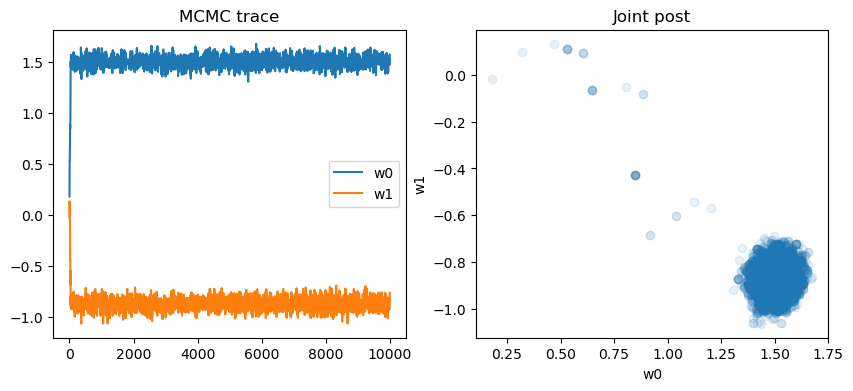

In [252]:
# Metropolis-Hastings
def metropolis_hastings(X, y, mu_prior, Sigma_prior, true_sigma, n_samples=10000, step_size=0.1):
    
    w_current = mu_prior.copy()
    samples = []
    n_accepted = 0

    for _ in tqdm(range(n_samples)):
        
        # q
        w_proposal = np.random.multivariate_normal(w_current, step_size * np.eye(2))
        
        # alpha
        log_alpha = log_posterior(w_proposal) - \
                    log_posterior(w_current)
        alpha = min(1, jnp.exp(log_alpha))
        
        # judge
        if np.random.rand() < alpha:
            w_current = w_proposal
            n_accepted += 1
        samples.append(w_current)
    
    print(f"Accept: {n_accepted / n_samples:.2f}")
    return np.array(samples)

# Sampling
mcmc_samples = metropolis_hastings(X, y, mu_prior, Sigma_prior, true_sigma, n_samples=10000, step_size=0.01)

# post
post(mcmc_samples)

## 3. BlackJAX implementation

In [253]:
initial_position = jnp.zeros(2)

### Random Walk MH

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21421.89it/s]


0.50374544
[ 1.498397  -0.8688955]


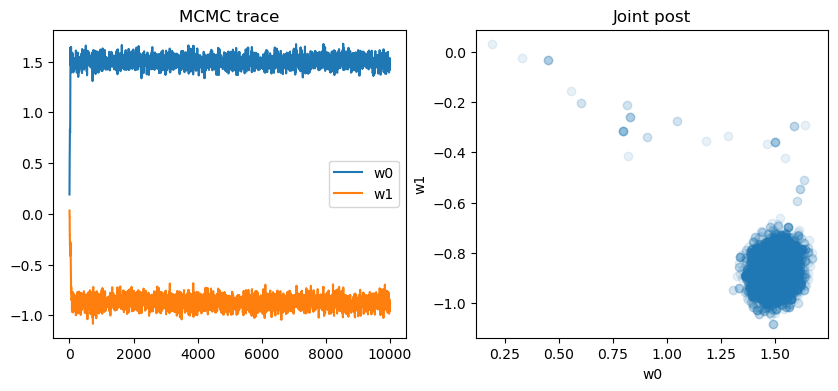

In [254]:
# Build the kernel
step_size = 0.1
random_walk = blackjax.additive_step_random_walk(log_posterior, blackjax.mcmc.random_walk.normal(step_size))
rw_kernel = jax.jit(random_walk.step)

# Initialize the state
state = random_walk.init(initial_position)

rng_key = jax.random.key(42)
states = []
for _ in tqdm(range(10000)):
    rng_key, sub_key = jax.random.split(rng_key)
    state, info = rw_kernel(sub_key, state)
    states.append(state.position)
print(info.acceptance_rate)
post(jnp.array(states))

### HMC

[ 1.4984909 -0.8670611]


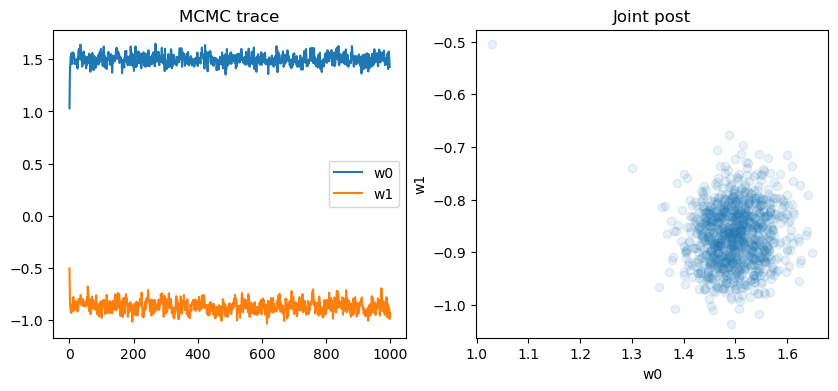

In [257]:
# Build the kernel
step_size = 1e-3
inv_mass_matrix = np.array([1., 1.])
num_integration_steps = 60
hmc = blackjax.hmc(log_posterior, step_size, inv_mass_matrix, num_integration_steps)
hmc_kernel = jax.jit(hmc.step)

# Initialize the state
initial_state = hmc.init(initial_position)

# inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

rng_key = jax.random.key(42)
state = inference_loop(rng_key, hmc_kernel, initial_state, 1_000)
post(state.position)

### NUTS

100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2033.11it/s]


[ 1.4650748 -0.8477551]


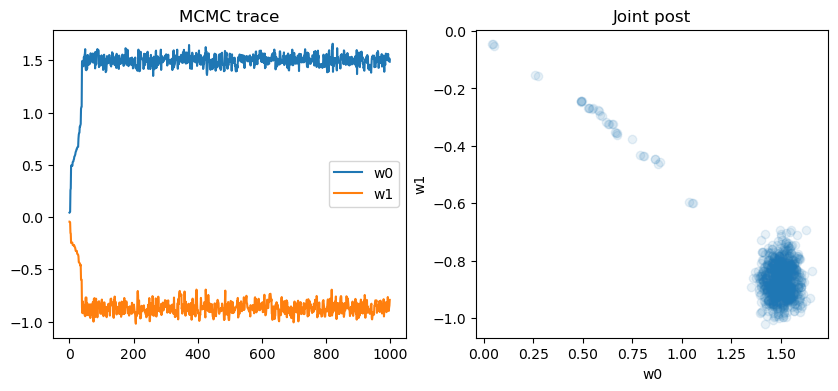

In [256]:
# Build the kernel
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
nuts = blackjax.nuts(log_posterior, step_size, inverse_mass_matrix)

# Initialize the state
state = nuts.init(initial_position)

# Iterate
rng_key = jax.random.key(42)
step = jax.jit(nuts.step)
states = []
for i in tqdm(range(1_000)):
    # nuts_key = jax.random.fold_in(rng_key, i)
    rng_key, nuts_key = jax.random.split(rng_key)
    state, info = step(nuts_key, state)
    # print(info)
    states.append(state.position)
post(jnp.array(states))